# Analysis pipeline for Specificity

## Preliminaries

In [41]:
%cd ~/code/textrec/

/Users/kcarnold/code/textrec


In [42]:
import datetime
import json
import pathlib

import pandas as pd
import numpy as np
import toolz
from IPython.display import Image, HTML

In [3]:
from textrec.paths import paths
from textrec import analysis_util, util
reload(analysis_util), reload(util)

(<module 'textrec.analysis_util' from '/Users/kcarnold/code/textrec/src/textrec/analysis_util.py'>,
 <module 'textrec.util' from '/Users/kcarnold/code/textrec/src/textrec/util.py'>)

Download Karpathy's version of the COCO captions dataset. This has the train-test split that is more commonly used in the literature, as well as pre-tokenized captions.

In [4]:
images = util.get_coco_captions()
images_by_split = toolz.groupby('split', images)

In [5]:
id2img = {img['cocoid']: img for img in images}

In [6]:
id2url = util.get_coco_id2url()

In [7]:
def show_images(indices):
    def img(idx):
        img = id2img[idx]
        captions = '\n'.join(
            '<div>{}</div>'.format(sent)
            for sent in toolz.pluck('raw', img['sentences'])
        )
        return '<div style="display: inline-block;"><div>{}/{}</div><img src="{}">{}</div>'.format(
            img['split'], img['cocoid'], id2url[img['cocoid']], captions)

    return '\n'.join(img(idx) for idx in indices)

In [8]:
HTML(show_images([images_by_split['val'][0]['cocoid']]))

## Load results of writing experiment

In [116]:
%run -m textrec.batch_analysis

In [117]:
participants = get_participants_by_batch()

In [118]:
participants.keys()

dict_keys(['2018-04-09', '2018-04-24', '2018-04-27', '2018-05-02'])

In [119]:
# summarize('2018-04-27')
summarize('2018-05-02')


h52x67
practice-0:specific:a black cat napping on a sunny unpainted wood bench in front of a red wall
final-0-0:specific:a cat sitting next to a glass bowl, looking up to the camera
final-0-1:specific:a shower with dirty glass doors has a beige towel hanging on the outside
final-0-2:specific:there is no image here 
practice-1:norecs:a man with black hair and glasses placing a large turkey into an upper oven
final-1-0:norecs:a bride and groom cutting their wedding cake, while a photographer guides them
final-1-1:norecs:a man helping his children fly a multicolor butterfly kite on a clear day
final-1-2:norecs:a passenger train approaching a small quaint station with a blue and white building on the background
practice-2:general:a black and red vehicle with bikes on top and people standing nearby with umbrellas. 
final-2-0:general:a busy street in a historic town with a red bus driving on the street. 
final-2-1:general:a tennis player hits a ball during a game 
final-2-2:general:a surfer

_____________________________________________get_log_analysis_raw - 5.7s, 0.1min
practice-0:specific:a black cat napping on a sunny unpainted wood bench in front of a red wall 
final-0-0:specific:an orange cat is laying near a wine glass with red wine
final-0-1:specific:a rusty and dirty shower in the bathroom has a tan towel over its handle
final-0-2:specific:there is a roll of toilet paper on the lid of the toilet in a small bathroom 
practice-1:general:a man with black hair and glasses placing a large turkey into an upper oven 
final-1-0:general:a photographer is helping the bride and groom cut the cake 
final-1-1:general:a man in a red shirt is helping his children fly a large rainbow-colored kite 
final-1-2:general:an old fashioned train is coming into the station 
practice-2:norecs:a black and red vehicle with bikes on top and people standing nearby with umbrellas. 
final-2-0:norecs:a red double-decker bus is coming down the street
final-2-1:norecs:a tennis player in a white shir

_____________________________________________get_log_analysis_raw - 2.9s, 0.0min
practice-0:norecs:a black cat napping on a sunny unpainted wood bench in front of a red wall
final-0-0:norecs:a beige cat sits on a textured beige rug behind a glass of red wine three quarters full on a brown table. 
final-0-1:norecs:a beige towel sits on a rack behind two glass translucent shower doors. a white toilet remains closed on the left. 
final-0-2:norecs:a white toilet with no cover has a roll of toilet paper on top of it. a white sink to the right has a mirror above it. 
practice-1:general:a man with black hair and glasses placing a large turkey into an upper oven 
final-1-0:general:three people stand in front of a table with a wedding cake. the groom and wife hold a knife to the cake along with the camerawoman. 
final-1-1:general:three people hold kites on the beach with others in the background. many other kites fly in the sky. there is water to the left. 
final-1-2:general:a train comes forwa

_____________________________________________get_log_analysis_raw - 3.1s, 0.1min
practice-0:general:a black cat napping on a sunny unpainted wood bench in front of a red wall 
final-0-0:general:a  brownish-orange cat with yellow eyes is look to his left past a glass of red wine  
final-0-1:general:a person is taking a shower in a shower with very opaque sliding doors  
final-0-2:general:a bathroom with one white sink and a white toilet with a toilet paper roll on the back lid sits next to the sink which has a mirror above it which shows the exact same toilet across the room 
practice-1:norecs:a man with black hair and glasses placing a large turkey into an upper oven
final-1-0:norecs:a obvious dressed bride and groom at a wedding reception are cutting into their wedding cake with the help of the photographer whose hand is guiding theirs
final-1-1:norecs:a man and his two children are flying multicolored kites on a sandy beach 
final-1-2:norecs:a brown colored train is parked at an outd

In [120]:
trial_data = get_trial_data('2018-05-02')

In [121]:
for trial in trial_data:
    trial['text'] = trial['text'].strip()

I had the wrong URL for one image when one person ran it.

In [122]:
trial_data = [trial for trial in trial_data if not (trial['stimulus'] == 431140 and trial['participant'] == 'h52x67')]

In [124]:
len(list(toolz.pluck('text', trial_data)))

134

In [125]:
# pd.DataFrame(trial_data).to_clipboard()

# Generate nAFC task

In [126]:
cap_vectorizer, caption_vecs = util.get_vectorized_captions()

In [127]:
caption_vecs.shape

(123287, 9952)

In [128]:
id2url[570528]

'http://images.cocodataset.org/train2017/000000570528.jpg'

In [129]:
def get_similar_images(caption, n=10):
    query_vec = cap_vectorizer.transform([caption])
    similarity = caption_vecs.dot(query_vec.T).A.ravel()
    return [images[idx]['cocoid'] for idx in np.argsort(similarity)[-n:][::-1]]
query_caption = trial_data[0]['text']
print(query_caption)
HTML(show_images(get_similar_images(query_caption)))

a cat sitting next to a glass bowl, looking up to the camera


In [130]:
'|'.join(id2url[idx] for idx in get_similar_images(query_caption))

'http://images.cocodataset.org/train2017/000000570528.jpg|http://images.cocodataset.org/train2017/000000300732.jpg|http://images.cocodataset.org/train2017/000000400999.jpg|http://images.cocodataset.org/train2017/000000449770.jpg|http://images.cocodataset.org/train2017/000000146767.jpg|http://images.cocodataset.org/train2017/000000548661.jpg|http://images.cocodataset.org/train2017/000000279386.jpg|http://images.cocodataset.org/train2017/000000350727.jpg|http://images.cocodataset.org/train2017/000000002295.jpg|http://images.cocodataset.org/train2017/000000537417.jpg'

In [131]:
def get_foil_set(*, stimulus, caption, rs):
    similar_images = get_similar_images(caption, n=10)
    if stimulus not in similar_images:
        print("Inserting", stimulus, 'into foil set')
        similar_images[-1] = stimulus
    rs.shuffle(similar_images)
    return similar_images
trial = trial_data[1]
get_foil_set(stimulus=trial['stimulus'], caption=trial['text'], rs=np.random.RandomState(1234))

[396295, 277466, 362711, 212082, 409842, 233737, 510852, 503200, 480798, 98257]

In [132]:
def make_task(trial, rs):
    stimulus = trial['stimulus']
    foil_set = get_foil_set(stimulus=stimulus, caption=trial['text'], rs=rs)
    res = dict(description=trial['text'], correct_idx=foil_set.index(stimulus))
    for i, idx in enumerate(foil_set):
        res[f'image_{i}_url'] = id2url[idx]
    return res

In [133]:
make_task(trial_data[0], np.random.RandomState(123))

Inserting 275449 into foil set


{'correct_idx': 8,
 'description': 'a cat sitting next to a glass bowl, looking up to the camera',
 'image_0_url': 'http://images.cocodataset.org/train2017/000000146767.jpg',
 'image_1_url': 'http://images.cocodataset.org/train2017/000000570528.jpg',
 'image_2_url': 'http://images.cocodataset.org/train2017/000000350727.jpg',
 'image_3_url': 'http://images.cocodataset.org/train2017/000000548661.jpg',
 'image_4_url': 'http://images.cocodataset.org/train2017/000000002295.jpg',
 'image_5_url': 'http://images.cocodataset.org/train2017/000000449770.jpg',
 'image_6_url': 'http://images.cocodataset.org/train2017/000000300732.jpg',
 'image_7_url': 'http://images.cocodataset.org/train2017/000000279386.jpg',
 'image_8_url': 'http://images.cocodataset.org/train2017/000000275449.jpg',
 'image_9_url': 'http://images.cocodataset.org/train2017/000000400999.jpg'}

### Load MTurk results so far

In [249]:
result_files = list((paths.data / 'mturk').glob('*-guesstheimage.csv'))
mturk_nafc_results = (
    pd.concat([pd.read_csv(str(f)) for f in result_files], axis=0, ignore_index=True)
    if len(result_files)
    else pd.DataFrame([], columns=['Answer.description', 'Answer.guesses', 'Input.correct_idx']))
mturk_nafc_results = mturk_nafc_results.rename(columns={'Input.correct_idx': 'correctIdx'})
print("Loaded", len(mturk_nafc_results), "guess task results")

Loaded 402 guess task results


In [250]:
mturk_nafc_results['guesses'] = mturk_nafc_results['Answer.guesses'].map(json.loads)

In [251]:
mturk_nafc_results['guess_indices'] = [[guess['idx'] for guess in row.guesses] for row in mturk_nafc_results.itertuples()]
mturk_nafc_results['guessed_right_sometime'] = [row.correctIdx in row.guess_indices for row in mturk_nafc_results.itertuples()]

In [252]:
mturk_nafc_results = mturk_nafc_results[mturk_nafc_results['guessed_right_sometime']]
print(len(mturk_nafc_results), "remain")

400 remain


In [257]:
mturk_nafc_results['num_guesses'] = [row.guess_indices.index(row.correctIdx) + 1 for row in mturk_nafc_results.itertuples()]

In [258]:
num_responses_by_caption = mturk_nafc_results.groupby('Answer.description').size().to_dict()

### Generate tasks remaining

In [255]:
trials_todo = [trial for trial in trial_data if num_responses_by_caption.get(trial['text'], 0) < 3]
len(trial_data), len(trials_todo)

(134, 2)

In [186]:
i = 0
while True:
    out_fn = paths.top_level / 'HITs' / f'{datetime.date.today().isoformat()}-{i}-nAFC.csv'
    if not out_fn.exists():
        break
    i += 1
out_fn

PosixPath('/Users/kcarnold/code/textrec/HITs/2018-05-14-1-nAFC.csv')

In [196]:
rs = np.random.RandomState(1234)
pd.DataFrame([make_task(trial, rs) for trial in trials_todo]).to_csv(out_fn, index=False)

Inserting 275449 into foil set
Inserting 200451 into foil set
Inserting 223777 into foil set
Inserting 431140 into foil set
Inserting 227326 into foil set
Inserting 200451 into foil set
Inserting 223777 into foil set
Inserting 247576 into foil set
Inserting 71815 into foil set
Inserting 240275 into foil set
Inserting 396295 into foil set
Inserting 431140 into foil set
Inserting 227326 into foil set
Inserting 200451 into foil set
Inserting 223777 into foil set
Inserting 247576 into foil set
Inserting 71815 into foil set
Inserting 240275 into foil set
Inserting 431140 into foil set
Inserting 200451 into foil set
Inserting 223777 into foil set
Inserting 247576 into foil set
Inserting 240275 into foil set
Inserting 431140 into foil set
Inserting 227326 into foil set
Inserting 200451 into foil set
Inserting 223777 into foil set
Inserting 247576 into foil set
Inserting 71815 into foil set
Inserting 240275 into foil set
Inserting 431140 into foil set
Inserting 227326 into foil set
Inserting 2

### Generate the actual HIT text...

In [193]:
from jinja2 import Template
html = Template(open(paths.top_level / 'HITs' / '2018-05-04-image-description-match.jinja.html').read()).render(dict(
    description='${description}',
    images=['${image_%d_url}' % i for i in range(10)]))

In [335]:
html2 = html
for k, v in make_task(trial_data[25], np.random.RandomState(1234)).items():
    html2 = html2.replace('${' + k + '}', str(v))
HTML('<div style="height: 1000px; position: relative;">'+html2+'</div>')
# print(html2)

Inserting 240275 into foil set


In [195]:
import subprocess
subprocess.Popen('pbcopy', stdin=subprocess.PIPE).communicate(html.encode('utf-8'))

(None, None)

# Analyze MTurk results

In [259]:
mturk_nafc_results.groupby('Answer.description').num_guesses.mean().to_dict()

{'a  brownish-orange cat with yellow eyes is look to his left past a glass of red wine': 1.0,
 'a bath room with a white toilet and a white washbasin': 10.0,
 'a bathroom has a white toilet and matching sink.': 1.6666666666666667,
 'a bathroom with a toilet and sink and with a roll of toilet paper on the toilet': 3.0,
 'a bathroom with one white sink and a white toilet with a toilet paper roll on the back lid sits next to the sink which has a mirror above it which shows the exact same toilet across the room': 1.6666666666666667,
 'a beige cat sits on a textured beige rug behind a glass of red wine three quarters full on a brown table.': 1.3333333333333333,
 'a beige towel hangs over the rightmost shower door both of which are wet with water': 1.0,
 'a beige towel sits on a rack behind two glass translucent shower doors. a white toilet remains closed on the left.': 2.6666666666666665,
 'a black and white photo or a large man and a woman cutting thwir wedding cake': 6.0,
 'a black and wh

In [201]:
%matplotlib inline

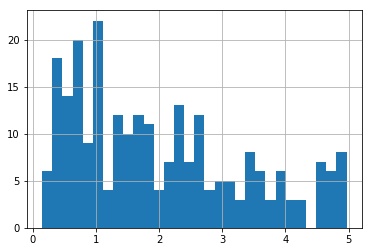

In [260]:
(mturk_nafc_results['WorkTimeInSeconds'][mturk_nafc_results['WorkTimeInSeconds'] < 5*60] / 60).hist(bins=30)

In [261]:
np.median(mturk_nafc_results['WorkTimeInSeconds'] / 60) * 9/60

0.5087499999999999

In [209]:
(
    15 # participants
    * 3 # conditions per participant
    * 3 # captions per condition
    - 1 # image not shown
) * 3 # annotators per description


402

In [ ]:
    * .24 # reward per annotator
) * 1.2 # MTurk 20% fee

Did the same worker see the same target image multiple times?

In [269]:
next(data.iterrows())[1]['Input.image_0_url']

'http://images.cocodataset.org/train2017/000000350727.jpg'

In [300]:
mturk_nafc_results['target_image_url'] = [row['Input.image_'+str(row['correctIdx'])+"_url"] for _, row in mturk_nafc_results.iterrows()]

In [302]:
bad_worker_image_pairs = set()
for worker_id, data in mturk_nafc_results.groupby('WorkerId'):
    target_images = [row['target_image_url'] for _, row in data.iterrows()]
    if len(target_images) != len(set(target_images)):
#         print(worker_id)
        value_counts = pd.Series(target_images).value_counts()
        value_counts = value_counts[value_counts > 1]
#         print(value_counts)
        for img in value_counts.index:
            bad_worker_image_pairs.add((worker_id, img))
bad_worker_image_pairs

annotation_row_is_bad = [
    (row['WorkerId'], row['target_image_url']) in bad_worker_image_pairs
    for _, row in mturk_nafc_results.iterrows()
]
mturk_nafc_results['row_is_bad'] = annotation_row_is_bad

In [303]:
mturk_nafc_results['row_is_bad'].mean()

0.6525

In [304]:
guess_results = mturk_nafc_results[~mturk_nafc_results['row_is_bad']].rename(columns={'Answer.description': 'text'})

In [305]:
len(mturk_nafc_results)

400

In [306]:
len(guess_results), len(trial_data)

(139, 134)

In [310]:
trial_data

[{'block': 0,
  'condition': 'specific',
  'idx_in_block': 0,
  'participant': 'h52x67',
  'stimulus': 275449,
  'text': 'a cat sitting next to a glass bowl, looking up to the camera'},
 {'block': 0,
  'condition': 'specific',
  'idx_in_block': 1,
  'participant': 'h52x67',
  'stimulus': 396295,
  'text': 'a shower with dirty glass doors has a beige towel hanging on the outside'},
 {'block': 1,
  'condition': 'norecs',
  'idx_in_block': 0,
  'participant': 'h52x67',
  'stimulus': 227326,
  'text': 'a bride and groom cutting their wedding cake, while a photographer guides them'},
 {'block': 1,
  'condition': 'norecs',
  'idx_in_block': 1,
  'participant': 'h52x67',
  'stimulus': 200451,
  'text': 'a man helping his children fly a multicolor butterfly kite on a clear day'},
 {'block': 1,
  'condition': 'norecs',
  'idx_in_block': 2,
  'participant': 'h52x67',
  'stimulus': 223777,
  'text': 'a passenger train approaching a small quaint station with a blue and white building on the backgr

In [326]:
annotator_level_data = pd.merge(
    pd.DataFrame(trial_data).rename(columns={'participant': 'writer'}),
    guess_results.rename(columns={'WorkerId': 'guesser'}).drop(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'RequesterAnnotation', 'guesses'], axis=1),
    on='text', validate='1:m', how='right')
annotator_level_data
    #.groupby().num_guesses.mean().to_frame('mean_num_guesses'),
#     left_on='text', right_index=True).groupby('condition').mean_num_guesses.aggregate(['mean', 'std'])

,block,condition,idx_in_block,writer,stimulus,text,Reward,CreationTime,MaxAssignments,AssignmentDurationInSeconds,...,Answer.feedback,Answer.guesses,Answer.images,Approve,Reject,guess_indices,guessed_right_sometime,num_guesses,row_is_bad,target_image_url
0,0,specific,0,h52x67,275449,"a cat sitting next to a glass bowl, looking up...",$0.24,Mon May 14 11:35:32 PDT 2018,3,3600,...,{},"[{""idx"":6,""timestamp"":1526323290561},{""idx"":1,...",http://images.cocodataset.org/train2017/000000...,NaN,NaN,"[6, 1, 0, 7, 5, 4, 8, 6, 3, 7, 5, 3, 0, 6, 9, ...",True,17,False,http://images.cocodataset.org/train2017/000000...
1,0,specific,0,h52x67,275449,"a cat sitting next to a glass bowl, looking up...",$0.24,Mon May 14 11:35:32 PDT 2018,3,3600,...,{},"[{""idx"":1,""timestamp"":1526324880672},{""idx"":7,...",http://images.cocodataset.org/train2017/000000...,NaN,NaN,"[1, 7, 2]",True,3,False,http://images.cocodataset.org/train2017/000000...
2,0,specific,1,h52x67,396295,a shower with dirty glass doors has a beige to...,$0.24,Mon May 14 11:35:32 PDT 2018,3,3600,...,{},"[{""idx"":0,""timestamp"":1526323064039}]",http://images.cocodataset.org/train2017/000000...,NaN,NaN,[0],True,1,False,http://images.cocodataset.org/train2017/000000...
3,0,specific,1,h52x67,396295,a shower with dirty glass doors has a beige to...,$0.24,Mon May 14 11:35:32 PDT 2018,3,3600,...,{},"[{""idx"":0,""timestamp"":1526322983192}]",http://images.cocodataset.org/train2017/000000...,NaN,NaN,[0],True,1,False,http://images.cocodataset.org/train2017/000000...
4,1,norecs,0,h52x67,227326,"a bride and groom cutting their wedding cake, ...",$0.24,Mon May 14 11:35:32 PDT 2018,3,3600,...,{},"[{""idx"":2,""timestamp"":1526323358258}]",http://images.cocodataset.org/train2017/000000...,NaN,NaN,[2],True,1,False,http://images.cocodataset.org/train2017/000000...
5,1,norecs,1,h52x67,200451,a man helping his children fly a multicolor bu...,$0.24,Mon May 14 11:35:32 PDT 2018,3,3600,...,{},"[{""idx"":5,""timestamp"":1526323114121},{""idx"":1,...",http://images.cocodataset.org/train2017/000000...,NaN,NaN,"[5, 1]",True,2,False,http://images.cocodataset.org/train2017/000000...
6,2,general,0,h52x67,247576,a busy street in a historic town with a red bu...,$0.20,Mon May 14 06:26:39 PDT 2018,3,3600,...,{},"[{""idx"":4,""timestamp"":1526304581186},{""idx"":9,...",http://images.cocodataset.org/train2017/000000...,NaN,NaN,"[4, 9, 6, 2]",True,4,False,http://images.cocodataset.org/train2017/000000...
7,2,general,0,h52x67,247576,a busy street in a historic town with a red bu...,$0.20,Mon May 14 06:26:39 PDT 2018,3,3600,...,{},"[{""idx"":6,""timestamp"":1526304801124},{""idx"":2,...",http://images.cocodataset.org/train2017/000000...,NaN,NaN,"[6, 2]",True,2,False,http://images.cocodataset.org/train2017/000000...
8,2,general,1,h52x67,71815,a tennis player hits a ball during a game,$0.20,Mon May 14 06:26:39 PDT 2018,3,3600,...,{},"[{""idx"":2,""timestamp"":1526303776210},{""idx"":9,...",http://images.cocodataset.org/train2017/000000...,NaN,NaN,"[2, 9]",True,2,False,http://images.cocodataset.org/train2017/000000...
9,2,general,2,h52x67,240275,a surfer riding a wave on a sunny day,$0.20,Mon May 14 06:26:39 PDT 2018,3,3600,...,{},"[{""idx"":6,""timestamp"":1526304630670},{""idx"":9,...",http://images.cocodataset.org/train2017/000000...,NaN,NaN,"[6, 9, 7, 1, 4, 5, 8, 7, 9, 0, 3, 2, 6, 2]",True,12,False,http://images.cocodataset.org/train2017/000000...


In [325]:
annotator_level_data.columns

Index(['block', 'condition', 'idx_in_block', 'writer', 'stimulus', 'text',
       'HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'guesser', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'correctIdx',
       'Input.description', 'Input.image_0_url', 'Input.image_1_url',
       'Input.image_2_url', 'Input.image_3_url', 'Input.image_4_url',
       'Input.image_5_url', 'Input.image_6_url', 'Input.image_7_url',
       'Input.image_8_url', 'Input.image_9_url', 'Answer.correctIdx',
       'Answer.feedback', 'Answer.guesses', 'Answer.images', 'Approve',
       'Reject

In [318]:
annotator_level_data.to_csv('annotator_level_data_2018-05-15.csv', index=False)

In [284]:
%load_ext rpy2.ipython

In [285]:
%%R
library(lme4)
library(ggplot2)

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)


In [312]:
%%R -i annotator_level_data
(model = lmer(num_guesses ~ condition + (1|writer) + (1|guesser) + (1|target_image_url), annotator_level_data))

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "guesses". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'dict'>'
  (name, str(e)))


Linear mixed model fit by REML ['lmerMod']
Formula: num_guesses ~ condition + (1 | writer) + (1 | guesser) + (1 |  
    target_image_url)
   Data: annotator_level_data
REML criterion at convergence: 680.1319
Random effects:
 Groups           Name        Std.Dev.
 guesser          (Intercept) 0.0000  
 writer           (Intercept) 0.2214  
 target_image_url (Intercept) 1.0586  
 Residual                     2.7231  
Number of obs: 139, groups:  guesser, 78; writer, 15; target_image_url, 9
Fixed Effects:
      (Intercept)    conditionnorecs  conditionspecific  
          2.78311            0.07985            0.87777  


In [314]:
%%R -i annotator_level_data
(null_model = lmer(num_guesses ~ (1|writer) + (1|guesser) + (1|target_image_url), annotator_level_data))

Linear mixed model fit by REML ['lmerMod']
Formula: num_guesses ~ (1 | writer) + (1 | guesser) + (1 | target_image_url)
   Data: annotator_level_data
REML criterion at convergence: 684.1384
Random effects:
 Groups           Name        Std.Dev.
 guesser          (Intercept) 0.0000  
 writer           (Intercept) 0.1499  
 target_image_url (Intercept) 1.1326  
 Residual                     2.7280  
Number of obs: 139, groups:  guesser, 78; writer, 15; target_image_url, 9
Fixed Effects:
(Intercept)  
      3.116  


In [316]:
%%R
library(pbkrtest)

In [317]:
%%R
(kr <- KRmodcomp(model, null_model))

F-test with Kenward-Roger approximation; computing time: 0.56 sec.
large : num_guesses ~ condition + (1 | writer) + (1 | guesser) + (1 | 
    target_image_url)
small : num_guesses ~ (1 | writer) + (1 | guesser) + (1 | target_image_url)
         stat     ndf     ddf F.scaling p.value
Ftest   1.348   2.000 125.614   0.99993  0.2635


In [328]:
%%R -i annotator_level_data
(glm.full = glmer(num_guesses ~ condition + (1|writer) + (1|target_image_url), annotator_level_data, family=poisson()))
#  (1|guesser)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_guesses ~ condition + (1 | writer) + (1 | target_image_url)
   Data: annotator_level_data
      AIC       BIC    logLik  deviance  df.resid 
 635.1018  649.7741 -312.5509  625.1018       134 
Random effects:
 Groups           Name        Std.Dev.
 writer           (Intercept) 0.2665  
 target_image_url (Intercept) 0.3101  
Number of obs: 139, groups:  writer, 15; target_image_url, 9
Fixed Effects:
      (Intercept)    conditionnorecs  conditionspecific  
          0.88902            0.08249            0.32501  


In [329]:
%%R
(glm.null = glmer(num_guesses ~ (1|writer) + (1|target_image_url), annotator_level_data, family=poisson()))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_guesses ~ (1 | writer) + (1 | target_image_url)
   Data: annotator_level_data
      AIC       BIC    logLik  deviance  df.resid 
 638.9612  647.7646 -316.4806  632.9612       136 
Random effects:
 Groups           Name        Std.Dev.
 writer           (Intercept) 0.2494  
 target_image_url (Intercept) 0.3168  
Number of obs: 139, groups:  writer, 15; target_image_url, 9
Fixed Effects:
(Intercept)  
      1.039  


In [330]:
%%R
confint(glm.full)

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Computing profile confidence intervals ...

  warnings.warn(x, RRuntimeWarning)


                        2.5 %    97.5 %
.sig01             0.12671006 0.4793793
.sig02             0.17736100 0.5742301
(Intercept)        0.55869229 1.2015178
conditionnorecs   -0.18309083 0.3475259
conditionspecific  0.08654964 0.5658251


In [331]:
%%R
anova(glm.full, glm.null, test="Chisq")

Data: annotator_level_data
Models:
glm.null: num_guesses ~ (1 | writer) + (1 | target_image_url)
glm.full: num_guesses ~ condition + (1 | writer) + (1 | target_image_url)
         Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)  
glm.null  3 638.96 647.76 -316.48   632.96                           
glm.full  5 635.10 649.77 -312.55   625.10 7.8594      2    0.01965 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [52]:
results = pd.DataFrame([dict(trial, specificity=specificity_lookup[trial['text'].strip()]) for trial in trial_data])
for col in ['condition', 'participant']:
    results[col] = results[col].astype('category')
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 7 columns):
block           71 non-null int64
condition       71 non-null category
idx_in_block    71 non-null int64
participant     71 non-null category
specificity     71 non-null float64
stimulus        71 non-null int64
text            71 non-null object
dtypes: category(2), float64(1), int64(3), object(1)
memory usage: 3.5+ KB


In [53]:
results.groupby('condition').specificity.mean()

condition
general     0.891667
norecs      0.808333
specific    0.808696
Name: specificity, dtype: float64

In [345]:
pd.DataFrame(trial_data).sample(frac=1.0).sort_values('stimulus').to_csv('trial_data_by_stimulus.csv')

# How many images does this caption apply to?

In [35]:
data = pd.read_csv("/Users/kcarnold/Downloads/Submitted Captions - Sheet1.csv").iloc[:,:6]

In [45]:
data

,block,idx_in_block,condition,participant,text,number of images it applies to (1 min limit),is_unique
0,0,0,specific,2vvj5m,a plate with pancakes with bananas and bacon w...,1,True
1,0,1,specific,2vvj5m,a red bird and green bird about to eat out of ...,1,True
2,0,2,specific,2vvj5m,a man is watching a field of sheep eat grass.,some,False
3,1,0,general,2vvj5m,a man is standing with a very large colorful k...,some,False
4,1,1,general,2vvj5m,a very large kitchen with a nice big island wi...,some,False
5,1,2,general,2vvj5m,a black cat with big green eyes with something...,a couple,False
6,2,0,norecs,2vvj5m,a small white and blue bird perched on a branc...,"1 exact, a few close",False
7,2,1,norecs,2vvj5m,a young girl in a red top and black skirt play...,1,True
8,2,2,norecs,2vvj5m,a yellow light hanging above a pedestrian cros...,3,False
18,0,0,norecs,m2xcp6,breakfast that consists of pancakes banana bac...,1,True


In [36]:
data.shape

(54, 6)

In [37]:
data = data.dropna().copy()
data.shape

(45, 6)

In [38]:
data['is_unique'] = (data.iloc[:,5] == '1')
data.is_unique.mean()

0.37777777777777777

In [49]:
data.groupby(['block', 'idx_in_block', 'condition']).is_unique.mean()

block  idx_in_block  condition
0      0             general      1.0
                     norecs       1.0
                     specific     1.0
       1             general      1.0
                     norecs       1.0
                     specific     1.0
       2             general      0.0
                     norecs       0.0
                     specific     0.0
1      0             general      0.0
                     norecs       0.0
                     specific     0.5
       1             general      0.0
                     norecs       0.5
                     specific     0.0
       2             general      0.0
                     norecs       0.5
                     specific     0.5
2      0             general      0.0
                     norecs       0.0
                     specific     0.5
       1             general      0.0
                     norecs       0.5
                     specific     0.0
       2             general      1.0
                   

In [46]:
data['participant'] = data['participant'].astype('category')
data['condition'] = data['condition'].astype('category')

In [48]:
data.groupby('condition').is_unique.mean()

condition
general     0.466667
norecs      0.333333
specific    0.333333
Name: is_unique, dtype: float64

In [47]:
%%R -i data
transformed <- art(is_unique ~ condition + (1|participant), data=data)
summary(transformed)
anova(transformed)

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df) 
Model: Mixed Effects (lmer)
Response: art(is_unique)

                  F Df Df.res Pr(>F)  
1 condition 0.36019  2     38 0.6999  
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 


In [26]:
example = trial_data[-1]['text']
example

'a yellow pedestrian crossing sign sittting below a signal light that is yellow. '

Concepts: traffic light. COCO doesn't have "pedestian crossing sign". There are 4330 images with traffic lights in them in COCO. That's way too much. Looking at Visual Genome.

Visual Genome synsets are potentially best, but they're sometimes inaccurate. e.g., "18 wheeler" is "cyclist.n.01". So let's consider an object a match if matches either the synset or object name.

In [30]:
vg_base = pathlib.Path('/Data/VisualGenome')
image_objects = json.load(open(vg_base / 'objects.json'))

In [31]:
img_by_id = {img['image_id']: img for img in image_objects}

In [37]:
obj_synsets = json.load(open(vg_base / 'object_synsets.json'))

In [63]:
obj_attributes = json.load(open(vg_base / 'attributes.json'))

In [66]:
len(obj_attributes), len(image_objects)

(108077, 108077)

In [68]:
obj_attributes[0].keys()

dict_keys(['image_id', 'attributes'])

In [70]:
attributes_by_img = {att['image_id']: att['attributes'] for att in obj_attributes}

In [71]:
attributes_by_img[61514]

[{'attributes': ['yellow', 'ellow'],
  'h': 247,
  'names': ['stop light', 'traffic signal'],
  'object_id': 1072926,
  'synsets': ['light.n.01'],
  'w': 102,
  'x': 393,
  'y': 1},
 {'h': 82,
  'names': ['yellow light'],
  'object_id': 1072927,
  'synsets': ['light.n.01'],
  'w': 89,
  'x': 393,
  'y': 81},
 {'attributes': ['yellow', 'warig', 'hagig', 'working', 'here'],
  'h': 76,
  'names': ['traffic light', 'light'],
  'object_id': 1072928,
  'synsets': ['traffic_light.n.01'],
  'w': 89,
  'x': 396,
  'y': 84},
 {'attributes': ['gloomy blue', 'blue', 'cloudy'],
  'h': 768,
  'names': ['sky'],
  'object_id': 1072929,
  'synsets': ['sky.n.01'],
  'w': 1020,
  'x': 1,
  'y': 0},
 {'attributes': ['here', 'horizontal'],
  'h': 432,
  'names': ['power lines', 'electric wires'],
  'object_id': 1072930,
  'synsets': ['power_line.n.01'],
  'w': 1022,
  'x': 1,
  'y': 0},
 {'attributes': ['black bolt',
   'yellow',
   'ellow',
   'diamod shaped',
   'here',
   'diamond shaped'],
  'h': 683,


In [74]:
# def has_object(obj_name):
#     return {
#         img['image_id'] for img in image_objects
#         if any(obj_name in '\n'.join(obj['names']) for obj in img['objects'])
#            }
def has_object(imgid, obj_name):
    return any(obj_name in '\n'.join(obj['names']) for obj in attributes_by_img[imgid])

In [75]:
# def has_synset(obj_synset):
#     return {
#         img['image_id'] for img in image_objects
#         if any(obj_synset in obj['synsets'] for obj in img['objects'])}
def has_synset(imgid, obj_synset):
    return any(obj_synset in obj['synsets'] for obj in attributes_by_img[imgid])

In [87]:
def has_obj_with_attr(imgid, obj_name, attr):
    return any(
        (obj_name in '\n'.join(obj['names'])) and (attr in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

def has_synset_with_attr(imgid, obj_synset, attr):
    return any(
        (obj_synset in obj['synsets']) and (attr in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

def has_obj_without_attr(imgid, obj_name, attr):
    return any(
        (obj_name in '\n'.join(obj['names'])) and (attr not in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

def has_synset_without_attr(imgid, obj_synset, attr):
    return any(
        (obj_synset in obj['synsets']) and (attr not in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

In [61]:
obj_synsets['pedestrian sign']

'sign.n.02'

In [88]:
# candidates = (
#     (has_object('pedestrian sign') | has_object('pedestrian crossing sign') | has_object('crossing sign') | has_object('sign')) &
#     (has_object('traffic light') | has_synset('traffic_light.n.01'))
# )
candidates = {
    imgid for imgid in attributes_by_img.keys()
    if (
        (
            has_object(imgid, 'pedestrian sign') |
            has_object(imgid, 'pedestrian crossing sign') |
            has_object(imgid, 'crossing sign') |
            has_obj_with_attr(imgid, 'sign', 'yellow')
        ) & (
            has_obj_without_attr(imgid, 'traffic light', 'red') |
            has_synset_without_attr(imgid, 'traffic_light.n.01', 'red')
        ))}
len(candidates)

246

In [91]:
show_images(candidates)

In [58]:
[img['image_id'] for img in image_objects if '61514' in img.get('image_url', '')]
#Image(img_by_id[61514]['image_url'])

[61514, 2361514]

In [55]:
img_by_id[61514]

{'image_id': 61514,
 'image_url': 'http://cs.stanford.edu/people/rak248/VG_100K_2/61514.jpg',
 'objects': [{'h': 21,
   'merged_object_ids': [],
   'names': ['bolt'],
   'object_id': 1072935,
   'synsets': ['thunderbolt.n.01'],
   'w': 42,
   'x': 595,
   'y': 123},
  {'h': 54,
   'merged_object_ids': [],
   'names': ['drawig of head'],
   'object_id': 1072939,
   'synsets': ['head.n.01'],
   'w': 37,
   'x': 577,
   'y': 152},
  {'h': 76,
   'merged_object_ids': [],
   'names': ['gree light'],
   'object_id': 1072937,
   'synsets': [],
   'w': 91,
   'x': 397,
   'y': 160},
  {'h': 206,
   'merged_object_ids': [],
   'names': ['lies'],
   'object_id': 1072936,
   'synsets': ['lie.n.01'],
   'w': 304,
   'x': 493,
   'y': 376},
  {'h': 56,
   'merged_object_ids': [],
   'names': ['pole'],
   'object_id': 1072940,
   'synsets': ['pole.n.01'],
   'w': 59,
   'x': 631,
   'y': 714},
  {'h': 432,
   'merged_object_ids': [],
   'names': ['power lines'],
   'object_id': 1072930,
   'synsets'

# Measuring Specificity

We use paired comparisons to analyze specificity and accuracy. For a target image $x$ and a fixed set of imposter images $Y$, the **specific accuracy** of a caption is the fraction of comparisons that chose $x$. 

We start with our dataset of paired comparisons.

In [17]:
captions = [
    "exactly how are both the dog and the person going to fit on that skateboard?",
    "the dark haired dog is trying to ride on the skateboard.",
    "a person in shorts and a black dog both have one foot on a skateboard.",
    "a dog with a black head and black legs and ears standing up has one black paw on a black skateboard with white wheels and a guy with black and white shoes and white socks has one foot on the skateboard also and there are bikes and other people in the background"
]

In [26]:
alternatives = 'dog-and-guy-on-skateboard just-dog-on-skateboard guy-on-skateboard-holding-dog dog-and-guy-next-to-skateboard'.split()
target = alternatives[0]
imposters = alternatives[1:]
applies_to = [
    'dog-and-guy-on-skateboard dog-and-guy-next-to-skateboard'.split(),
    'just-dog-on-skateboard'.split(),
    'dog-and-guy-on-skateboard'.split(),
    'dog-and-guy-on-skateboard just-dog-on-skateboard guy-on-skateboard-holding-dog dog-and-guy-next-to-skateboard'.split()
]
applies_to = {cap: tgts for cap, tgts in zip(captions, applies_to)}
applies_to

{'a dog with a black head and black legs and ears standing up has one black paw on a black skateboard with white wheels and a guy with black and white shoes and white socks has one foot on the skateboard also and there are bikes and other people in the background': ['dog-and-guy-on-skateboard',
  'just-dog-on-skateboard',
  'guy-on-skateboard-holding-dog',
  'dog-and-guy-next-to-skateboard'],
 'a person in shorts and a black dog both have one foot on a skateboard.': ['dog-and-guy-on-skateboard'],
 'exactly how are both the dog and the person going to fit on that skateboard?': ['dog-and-guy-on-skateboard',
  'dog-and-guy-next-to-skateboard'],
 'the dark haired dog is trying to ride on the skateboard.': ['just-dog-on-skateboard']}

In [40]:
import random
random.seed(0)
pairs = [[target, imposter] for imposter in imposters]
for pair in pairs:
    random.shuffle(pair)
pairs

[['dog-and-guy-on-skateboard', 'just-dog-on-skateboard'],
 ['dog-and-guy-on-skateboard', 'guy-on-skateboard-holding-dog'],
 ['dog-and-guy-next-to-skateboard', 'dog-and-guy-on-skateboard']]

In [41]:
def fake_answer_pairs_for_caption(applies, pairs):
    outcomes = []
    for a, b in pairs:
        choices = []
        if a in applies:
            choices.append(0)
        if b in applies:
            choices.append(1)
        if len(choices) == 0:
            choices = [0, 1]
        outcomes.append(random.choice(choices))
    return outcomes
fake_answer_pairs_for_caption(applies_to[captions[0]], pairs)

[0, 0, 1]

In [56]:
fake_comparisons_data = []
for caption in captions:
    for annotator in range(5):
        for pair, outcome in zip(pairs, fake_answer_pairs_for_caption(applies_to[caption], pairs)):
            picked = pair[outcome]
            fake_comparisons_data.append(dict(
                caption=caption,
                annotator=annotator,
                pair=pair,
                picked=picked))

In [57]:
data = pd.DataFrame(fake_comparisons_data)
len(data)

60

In [58]:
data['picked_correct'] = data['picked'] == 'dog-and-guy-on-skateboard'
data.groupby('caption').picked_correct.mean().sort_values()

caption
a dog with a black head and black legs and ears standing up has one black paw on a black skateboard with white wheels and a guy with black and white shoes and white socks has one foot on the skateboard also and there are bikes and other people in the background    0.266667
the dark haired dog is trying to ride on the skateboard.                                                                                                                                                                                                                 0.466667
exactly how are both the dog and the person going to fit on that skateboard?                                                                                                                                                                                             0.800000
a person in shorts and a black dog both have one foot on a skateboard.                                                                                                    

# Final analyses

We find a main effect of writing condition on outcome specificity.

In [37]:
%load_ext rpy2.ipython

In [12]:
results = pd.DataFrame([
    dict(participant_id=participant_id, condition=condition)
    for participant_id in 'abc def ghi'.split() for condition in 'general specific norecs'.split()
])
results['participant_id'] = results['participant_id'].astype('category')
results['condition'] = results['condition'].astype('category')
results['specificity'] = np.random.randn(len(results))

In [38]:
%%R
#install.packages("ARTool")
library(ARTool)

In [39]:
%%R -i results
summary(results)

     block          condition   idx_in_block     participant  specificity    
 Min.   :0.000   general :24   Min.   :0.0000   36x2r3 : 9   Min.   :0.2000  
 1st Qu.:0.000   norecs  :24   1st Qu.:0.0000   3vf5fg : 9   1st Qu.:0.7750  
 Median :1.000   specific:23   Median :1.0000   692c8j : 9   Median :1.0000  
 Mean   :1.014                 Mean   :0.9859   77j4mf : 9   Mean   :0.8359  
 3rd Qu.:2.000                 3rd Qu.:2.0000   gg65g6 : 9   3rd Qu.:1.0000  
 Max.   :2.000                 Max.   :2.0000   jvccx2 : 9   Max.   :1.0000  
                                                (Other):17                   
    stimulus          text          
 Min.   : 71815   Length:71         
 1st Qu.:223777   Class :character  
 Median :240275   Mode  :character  
 Mean   :254672                     
 3rd Qu.:275449                     
 Max.   :431140                     
                                    


In [41]:
%%R -i results
transformed <- art(specificity ~ condition + (1|participant), data=results)
summary(transformed)
anova(transformed)

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df) 
Model: Mixed Effects (lmer)
Response: art(specificity)

                  F Df Df.res  Pr(>F)  
1 condition 0.90884  2 61.179 0.40836  
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 
